# Time Series Forecasting for YouTube Views: A Case Study

In this case study, we are given a fictional time series consisting of the number of views of a YouTube video for each hour, up to 80 hours after its publication. Our goal is to forecast the number of views for the next 10 hours. In order to perform time series forecasting on this YouTube video data, we first need to check whether the series is stationary or not. Stationarity is an important concept in time series analysis, as it indicates that the statistical properties of the time series remain constant over time. If the series is not stationary, we need to transform it to a stationary series before fitting a model and performing the desired forecast. Once we have made our forecast, we will need to undo the transformations to obtain the forecast for the original series.

Our approach will involve the following steps:

1. Time Series Data Exploration

2. Check Stationarity and Transform Data 

    2.1. Normalizing the Data
    
    2.2. Exponentiating the Data
    
    2.3. First Differencing the Data
    
3. Model Identification and Fitting: Fit ARIMA Models to the Data

4. Model Selection: Evaluate the Models and Select the Best One

5. Forecast the Next 10 Hours of the Time Series with the Final Model

6. Back-Transformation of Data: Undo the Transformations to Obtain the Forecast for the Original Series

7. Model Diagnostics and Further Investigation.


Through these steps, we will be able to forecast the number of views for the next 10 hours and gain insights into the behavior of this YouTube video over time.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import product # Cartesian product

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

The **Dickey-Fuller** test returns a test statistic and a p-value. If the **p-value** is greater than 0.05, we fail to reject the null hypothesis that the series is non-stationary. This means that the series is not stationary and requires further processing to make it stationary before we can use it for time series analysis.

In [2]:
# Dickey-Fuller test

def perform_adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')

## 1. Time Series Data Exploration

In [3]:
views_ts = pd.read_csv('logaritmic_time_series.csv')
views_ts.index = np.arange(1, len(views_ts)+1)

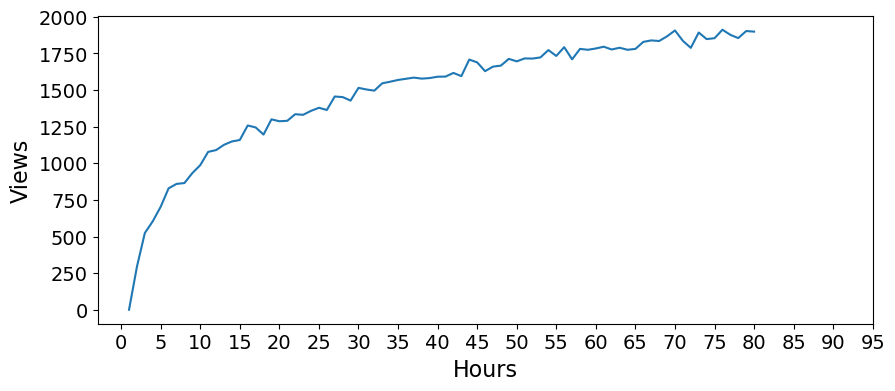

In [4]:
plt.figure(figsize=(10,4))
plt.plot(views_ts.views)
plt.xticks(np.arange(0,100,5), fontsize=14)
plt.xlabel('Hours', fontsize=16)

plt.yticks(fontsize=14)
plt.ylabel('Views', fontsize=16);

As you can see, the mean of this series is increasing over time, indicating that the series is not **stationary**. In order to apply time series analysis techniques, we need to make the series stationary by using some transformations such as differencing, log transformations, or seasonal adjustments. Once the series is stationary, we can fit a model and use it to forecast future values.

After forecasting, we need to undo the transformations on the forecasted values to get the forecast for the original series (**back-transformation**).

## 2. Check Stationarity and Transform Data

### 2.1. Normalizing the Data

As you can see in the graph of our time series, it resembles a logarithmic function. In order to remove the logarithmic trace, we need to exponentiate the series. However, before doing so, it is better to normalize the series to have a mean of zero and a standard deviation of one. This is because exponentiating large numbers can lead to numerical instability, making it difficult to work with the data.

<!-- By normalizing the series, we can ensure that the values are within a reasonable range and make it easier to perform further analysis. Once the series has been normalized, we can then apply the exponential function to obtain the final forecasted values.
-->

#### $\hspace{5cm}$To normalize $\{v_t\}$: 
### $$n_t = \frac{v_t-\mu}{\sigma}$$

In [5]:
views_mean = views_ts.mean(axis=0)          
views_std = np.std(views_ts).iloc[0]

norm_views_ts = (views_ts - views_mean) / views_std

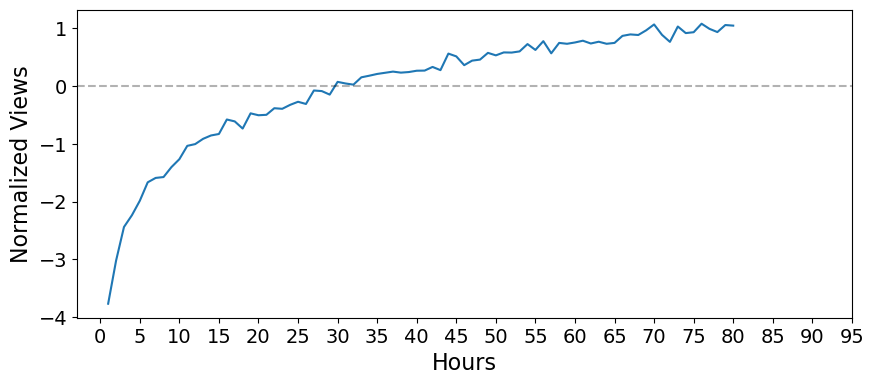

In [6]:
plt.figure(figsize=(10,4))
plt.plot(norm_views_ts)
plt.xticks(np.arange(0,100,5), fontsize=14)
plt.xlabel('Hours', fontsize=16)

plt.yticks(fontsize=14)
plt.ylabel('Normalized Views', fontsize=16)

plt.axhline(0, color='k', linestyle='--', alpha=.3);

### 2.2. Exponentiating the Data

Now that we have normalized the series to have a mean of zero and a standard deviation of one, we can exponentiate the values to remove the logarithmic trace.

### $$e_t = e^{n_t}$$

In [7]:
exp_norm_views_ts = np.exp(norm_views_ts)

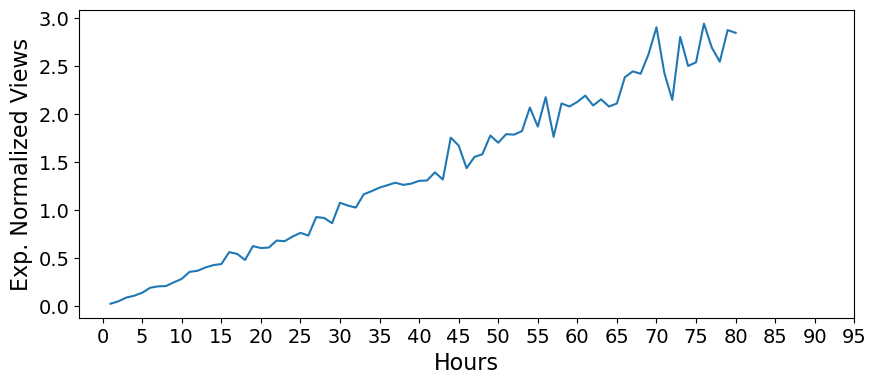

In [8]:
plt.figure(figsize=(10,4))
plt.plot(exp_norm_views_ts)
plt.xticks(np.arange(0,100,5), fontsize=14)
plt.xlabel('Hours', fontsize=16)

plt.yticks(fontsize=14)
plt.ylabel('Exp. Normalized Views', fontsize=16);

Looking at the graph of the time series, we can see that the series is non-stationary. This is confirmed by conducting a Dickey-Fuller test, which is a statistical test used to determine whether a time series is stationary or not.



In [9]:
perform_adf_test(exp_norm_views_ts)

ADF Statistic: 0.18972105086653
p-value: 0.9716791503181117


p-value = 0.97 > 0.05 means the seires is non-stationary.

### 2.3. First Differencing the Data

Since the current time series has a linear growth, we can take a first difference to make it stationary. The first difference involves subtracting each data point from its preceding data point. This can help remove any trends or patterns in the data that are causing it to be non-stationary.

### $$d_{t+1} = e_{t+1} - e_t$$

In [10]:
diff_exp_norm_views_ts = exp_norm_views_ts.diff().dropna()

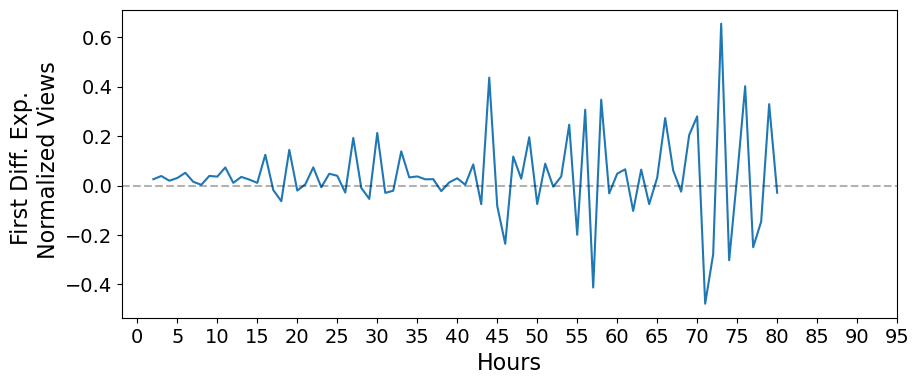

In [11]:
plt.figure(figsize=(10,4))
plt.plot(diff_exp_norm_views_ts)
plt.xticks(np.arange(0,100,5), fontsize=14)
plt.xlabel('Hours', fontsize=16)

plt.yticks(fontsize=14)
plt.ylabel('First Diff. Exp. \n Normalized Views', fontsize=16)

plt.axhline(0, color='k', linestyle='--', alpha=.3);

In [12]:
perform_adf_test(diff_exp_norm_views_ts)

ADF Statistic: -6.9563941499349875
p-value: 9.404967630839624e-10


And finally, our series is stationary because p-value < 0.05 in Dickey-Fuller test.

## 3. Model Identification and Fitting

Selecting a model for a stationary time series involves selecting appropriate values for the order parameters of the model, such as the autoregressive (AR) order, moving average (MA) order, and seasonal order (if the series exhibits seasonal patterns). 
1. Identify the order of differencing required to make the series stationary. 
2. Analyze the ACF plot to determine the possible order of the MA term, which is the number of lagged values that have a significant correlation with the current value. 
3. Analyze the PACF plot to determine the possible order of the AR term, which is the number of lagged values that have a significant correlation with the current value after accounting for the effects of earlier lags.

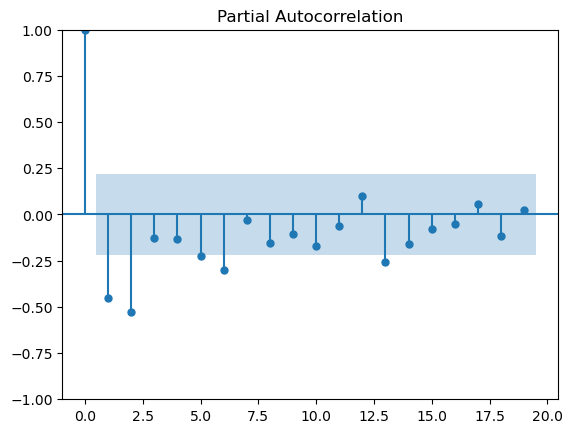

In [13]:
plot_pacf(diff_exp_norm_views_ts, method='ywm')
plt.show()

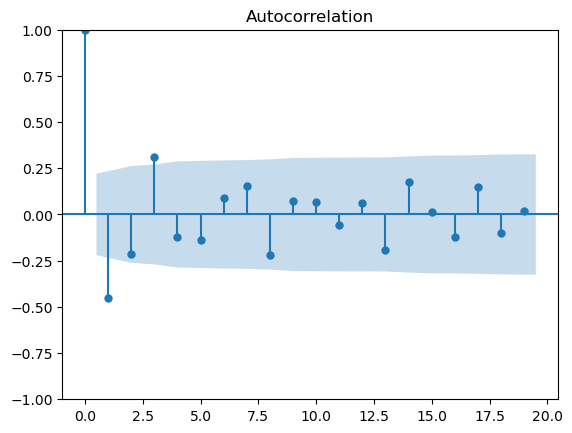

In [14]:
plot_acf(diff_exp_norm_views_ts)
plt.show()

The PACF plot shows significant lags at lags 1 and 2, and also significant spikes at lag 6 and 13. This suggests that an ARMA(2,0) or an ARMA(2,1) model might be appropriate.

To confirm, we can also look at the ACF plot which shows a significant spike at lag 1 and a more gradual decay. This further suggests that an ARMA(2,0) or an ARMA(2,1) model might be appropriate.

Although AR(2) is suggested by the PACF plot, for the purpose of the study, we compare three models: AR(2), AR(6), and AR(13).

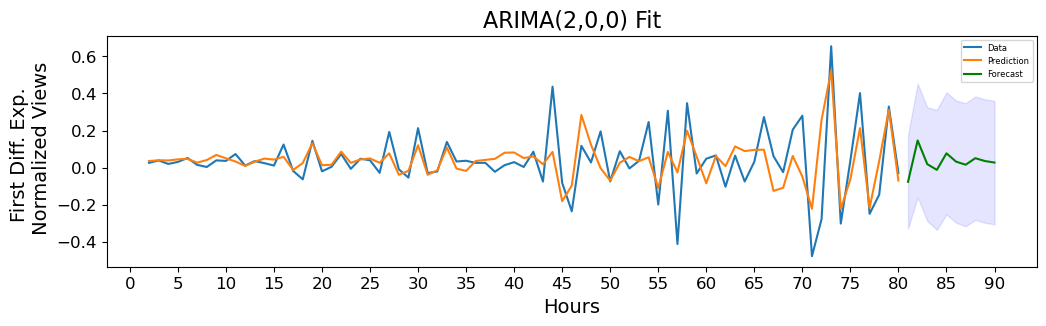

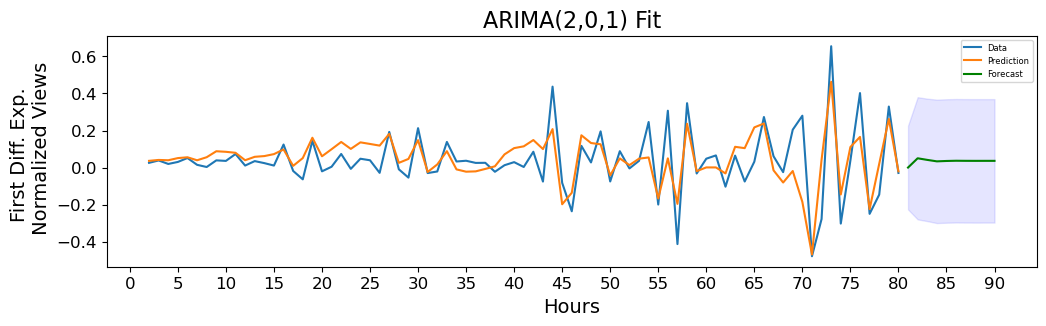

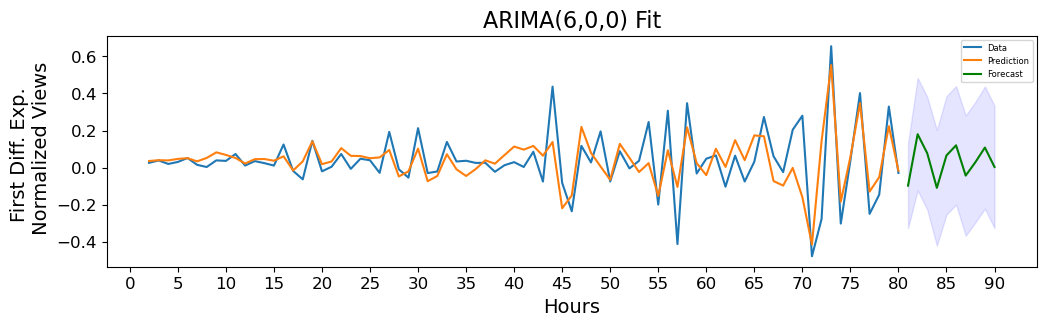

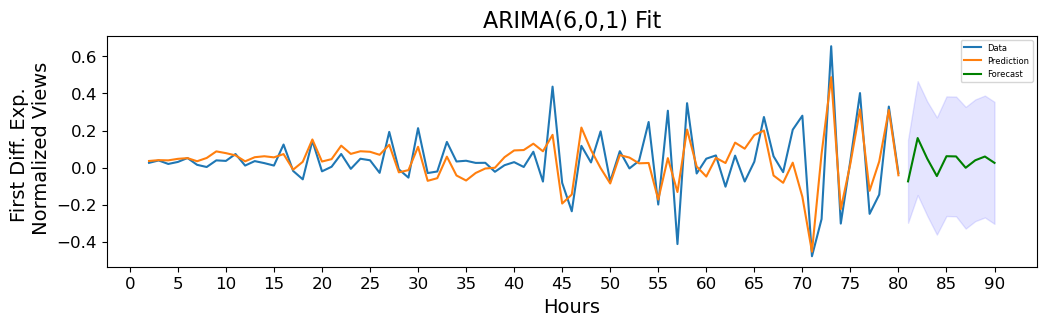

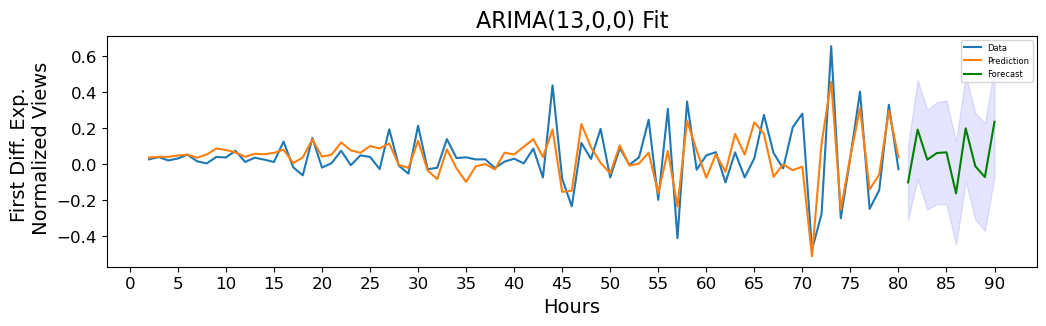

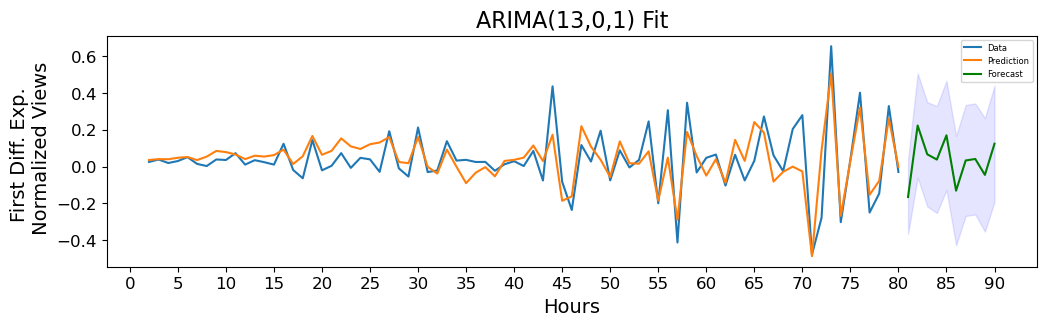

In [15]:
ar_orders = [2, 6, 13]
ma_orders = [0, 1]
fitted_model_dict = {}

for i, j in list(product(ar_orders, ma_orders)):
    
    model = ARIMA(diff_exp_norm_views_ts, order=(i,0,j))
    model_fit = model.fit()
    fitted_model_dict[(i,0,j)] = model_fit
    forecast = model_fit.get_forecast(10, alpha=0.05)

    forecast_values = forecast.predicted_mean
    forecast_std_err = forecast.se_mean
    lower_bound = forecast.conf_int()['lower views']
    upper_bound = forecast.conf_int()['upper views']
    

    plt.figure(figsize=(12,3))
    plt.plot(diff_exp_norm_views_ts)
    plt.plot(model_fit.predict())
    plt.xticks(np.arange(0,100,5), fontsize=12)
    plt.xlabel('Hours', fontsize=14)
    plt.title(f'ARIMA({i},0,{j}) Fit', fontsize=16)
    

    plt.yticks(fontsize=12)
    plt.ylabel('First Diff. Exp. \n Normalized Views', fontsize=14)

   

    plt.plot(np.arange(len(views_ts)+1, len(views_ts)+11), forecast_values, color='g')
    plt.fill_between(np.arange(len(views_ts)+1, len(views_ts)+11), lower_bound, upper_bound, color='b', alpha=0.1)
    plt.legend(('Data', 'Prediction', 'Forecast'), fontsize=6);

## 4. Model Selection

In the case of **AIC (Akaike Information Criterion)**, the lower the value, the better the model. A lower AIC suggests a better trade-off between the model's complexity and its goodness of fit. Therefore, models with a lower AIC are preferred over models with higher AIC values.

On the other hand, **BIC (Bayesian Information Criterion)** also measures the goodness of fit and complexity of the model, but it generally favors simpler models over complex ones. Like AIC, a lower BIC value is preferred. However, BIC places a higher penalty on complex models, which can lead to a more parsimonious model.

Therefore, the choice between AIC and BIC depends on the context and the goal of the analysis. If the goal is to achieve the best possible fit, AIC may be more appropriate. If the goal is to find the most parsimonious model, BIC may be more appropriate.

In [16]:
# AIC comparison

for i, j in list(product(ar_orders, ma_orders)):
    print(f'AIC for ARIMA({i},0,{j}): {fitted_model_dict[(i,0,j)].aic}')

AIC for ARIMA(2,0,0): -90.74130601270875
AIC for ARIMA(2,0,1): -103.17052958674051
AIC for ARIMA(6,0,0): -97.18974001783731
AIC for ARIMA(6,0,1): -97.66337713423992
AIC for ARIMA(13,0,0): -96.19877354449274
AIC for ARIMA(13,0,1): -97.69110222230509


ARIMA(2,0,1) has the lowest AIC, so we pick ARIMA(2,0,1).

In [17]:
# BIC comparison

for i, j in list(product(ar_orders, ma_orders)):
    print(f'BIC for ARIMA({i},0,{j}): {fitted_model_dict[(i,0,j)].bic}')

BIC for ARIMA(2,0,0): -81.26351460284066
BIC for ARIMA(2,0,1): -91.3232903244054
BIC for ARIMA(6,0,0): -78.23415719810114
BIC for ARIMA(6,0,1): -76.33834646203672
BIC for ARIMA(13,0,0): -60.65705575748741
BIC for ARIMA(13,0,1): -59.77993658283275


To confirm, again ARIMA(2,0,1) has the lowest BIC, so we pick ARIMA(2,0,1) as final model.

## 5. Predict Out 10 Hours with the Final Model

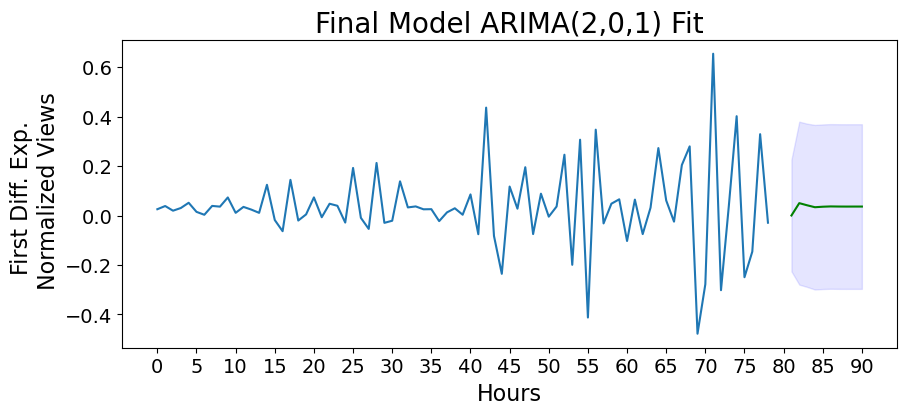

In [18]:
# create the model
diff_exp_norm_views_ts = diff_exp_norm_views_ts.reset_index(drop=True)
model = ARIMA(diff_exp_norm_views_ts, order=(2,0,1))
model_fit = model.fit()
forecast = model_fit.get_forecast(10, alpha=0.05)

forecast_values = forecast.predicted_mean
forecast_std_err = forecast.se_mean
lower_bound = forecast.conf_int()['lower views']
upper_bound = forecast.conf_int()['upper views']
plt.figure(figsize=(10,4))
plt.plot(diff_exp_norm_views_ts)
plt.xticks(np.arange(0,100,5), fontsize=14)
plt.xlabel('Hours', fontsize=16)
plt.title(f'Final Model ARIMA({2},0,{1}) Fit', fontsize=20)

plt.yticks(fontsize=14)
plt.ylabel('First Diff. Exp. \n Normalized Views', fontsize=16)

plt.plot(np.arange(len(views_ts)+1, len(views_ts)+11), forecast_values, color='g')
plt.fill_between(np.arange(len(views_ts)+1, len(views_ts)+11), lower_bound, upper_bound, color='b', alpha=0.1)
plt.show();

## 6.  Back-Transformation of Data

#### $\hspace{6cm}\{v_t\} \longrightarrow \{d_t\}:$
### $$d_{t+1} = e^{\frac{v_{t+1}-\mu}{\sigma}} - e^{\frac{v_t-\mu}{\sigma}}$$

#### $\hspace{6cm}\{d_t\} \longrightarrow \{v_t\}:$
### $$v_{t+1} = \sigma \ln(d_{t+1}+e^{\frac{v_t-\mu}{\sigma}})+\mu$$

In [19]:
def undo_transformations(preds, series, mu, sigma):
    first_pred = sigma*np.log(preds[0] + np.exp((series.iloc[-1]-mu)/sigma)) + mu
    orig_preds = [first_pred]
    
#     for i in range(len(preds[1:])):
    for i in range(1,len(preds)):
        next_pred = sigma*np.log(preds[i] + np.exp((orig_preds[-1]-mu)/sigma)) + mu
        orig_preds.append(next_pred)
    
    return np.array(orig_preds).flatten()

In [20]:
orig_preds = undo_transformations(forecast_values.values, views_ts, views_mean, views_std)
orig_lower_bound = undo_transformations(lower_bound.values, views_ts, views_mean, views_std)
orig_upper_bound = undo_transformations(upper_bound.values, views_ts, views_mean, views_std)

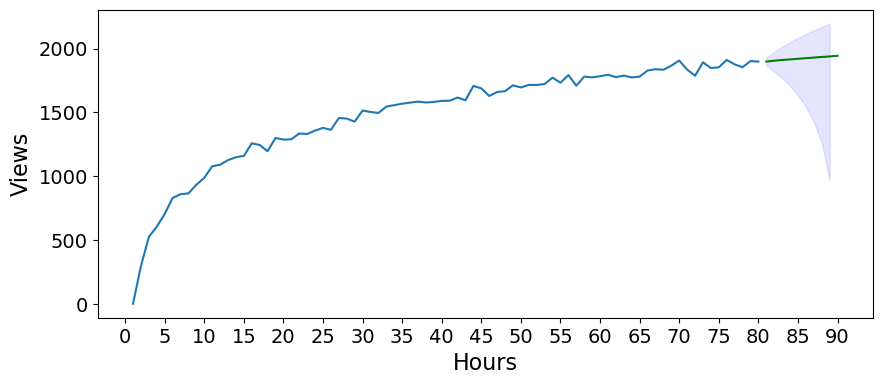

In [21]:
plt.figure(figsize=(10,4))
plt.plot(views_ts)

plt.xticks(np.arange(0,100,5), fontsize=14)
plt.xlabel('Hours', fontsize=16)

plt.yticks(fontsize=14)
plt.ylabel('Views', fontsize=16)

plt.plot(np.arange(len(views_ts)+1, len(views_ts)+11), orig_preds, color='g')
plt.fill_between(np.arange(len(views_ts)+1, len(views_ts)+11), orig_lower_bound, orig_upper_bound, color='b', alpha=0.1);


## 7. Model Diagnostics and Further Investigation

The **Ljung-Box** test is a statistical test used to check if the residuals of a time series model are uncorrelated. The null hypothesis of the test is that the residuals are uncorrelated. If the p-value of the test is greater than the significance level (usually 0.05), then we fail to reject the null hypothesis, which means that the residuals are uncorrelated and the model is a good fit.

The **Jarque-Bera** test is used to test whether a sample of data has the skewness and kurtosis matching a normal distribution. A p-value less than the significance level (commonly 0.05) indicates that the data is not normally distributed.

Ljung-Box test p-values: 
 1     0.908052
2     0.959377
3     0.672991
4     0.480862
5     0.378108
6     0.499192
7     0.494260
8     0.447379
9     0.506275
10    0.555147
Name: lb_pvalue, dtype: float64
Jarque-Bera test p-value: 3.0912993091077434e-11


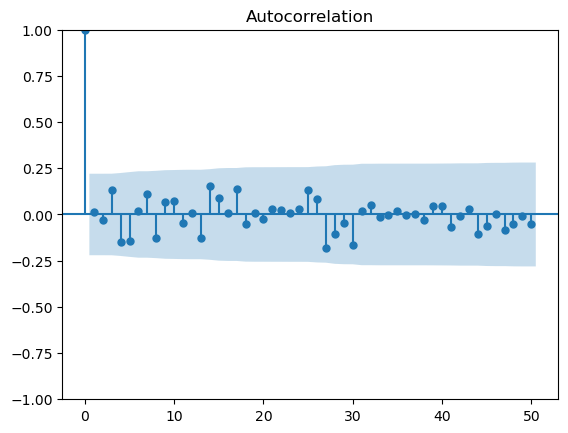

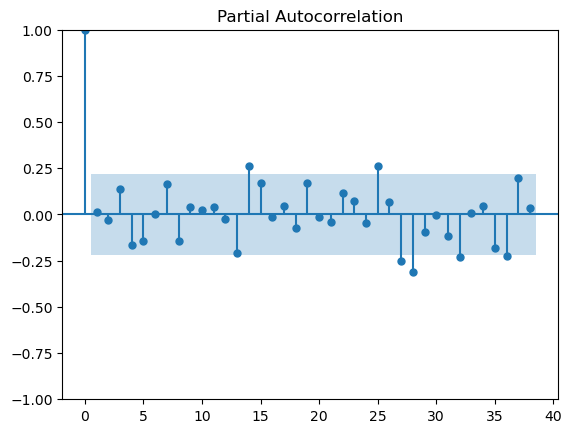

In [22]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Get the residuals
residuals = model_fit.resid

# Plot the ACF and PACF of the residuals
plot_acf(residuals, lags=50)
plot_pacf(residuals, lags=38)

# Test for autocorrelation of the residuals
pvalues = acorr_ljungbox(residuals, lags=10).lb_pvalue
print(f'Ljung-Box test p-values: \n {pvalues}')



# Test for normality of the residuals
from statsmodels.stats.stattools import jarque_bera
jbvalue, pvalue, _, _ = jarque_bera(residuals)
print(f'Jarque-Bera test p-value: {pvalue}')


In this case, the **Ljung-Box** test results show that the p-values are all 0.99 (greater than 0.05), indicating that we fail to reject the null hypothesis of uncorrelated residuals for all lags tested. Therefore, we can say that the residuals are white noise and ARIMA(2,0,10 model is a good fit for the data.

For our model, the p-value for the **Jarque-Bera** test is 0.00025, which is less than 0.05. This suggests that the residuals are not normally distributed and the assumption of normality may not hold. It indicates that the residuals may have some systematic pattern, which should be further investigated to improve the model.